`Cortix` 2019 **07Aug2019**

# Droplets-in-a-Vortex Example
* This is part of the [Cortix](https://cortix.org) Notebook [guides](https://github.com/dpploy/cortix-nb)
([index](https://github.com/dpploy/cortix-nb/blob/master/droplet.ipynb)).
* Select each of the cells below and run them sequentially (use the run button, `>|` on the tool bar or use the `Cell` option on the menu bar).
* Alternatively, on the menu bar run all cells: `Cell -> Run All`.

$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\vvar}{\boldsymbol{v}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\Power}{\mathcal{P}}
  \newcommand{\bm}[1]{{\boldsymbol{#1}}}
$

---
## Table of Contents
* [Introduction](#intro)
  - [Droplet motion model](#dropletmodel)
  - [Vortex motion model](#vortexmodel)
* [Write a Cortix run file](#runfile)
* [Verify the network connectivity](#net)
* [Run the network simulation](#run)
* [Results inspection through Cortix](#inspect)
   - [Results: All droplets](#dataplot)
   - [Results: Individual droplets](#droplet)
---

## Introduction<a id="intro"></a>

This Cortix use-case simulates the motion of a swarm of droplets in a vortex stream. 
It consists of two modules, namely, a `Droplet` module used to model the droplet dynamics, 
and a `Vortex` module used to model the effects of the surrounding air on the falling 
droplets. The `Droplet` module is instantiated as many times as there are droplets in 
the simulation while a single `Vortex` module is connected to all `Droplet` 
instances. The communication between modules entails a two-way data exchange between 
the `Vortex` module and the `Droplet` modules, where `Droplet` sends  
its position to `Vortex` and `Vortex` returns the air velocity to `Droplet` at the given position.

### Droplet motion model<a id="dropletmodel"></a>

The equation of motion of a spherical droplet can be written as:
    \begin{equation*}
        m_\text{d}\,d_t\bm{v} = \bm{f}_\text{d} + \bm{f}_\text{b} ,
    \end{equation*}
where
   \begin{equation*}
       \bm{f}_\text{d} = c_\text{d} A \, \rho_\text{f}\, 
       \frac{||\bm{v} - \bm{v}_\text{f}||}{2}\,(\bm{v} - \bm{v}_\text{f}) ,
    \end{equation*}
is the form drag force on the droplet,
    \begin{equation*}
    \bm{f}_\text{b} = (m_\text{d} - m_\text{f})\,g \hat{z} ,
    \end{equation*} 
is the buoyancy force on the droplet,
    \begin{equation*}
        c_\text{d}(Re) = 
    \begin{cases}
        \frac{24}{Re}   & Re < 0.1\\
        \Bigl(\sqrt{\frac{24}{Re}} + 0.5407\Bigr)^2 & 0.1 \leq Re < 6000 \\
        0.44    & Re \geq 6000
    \end{cases}
    \end{equation*}
is the drag coefficient as a function of Reynold's number, 
$Re=\frac{\rho_\text{f}\,||\bm{v}||\,d}{\mu_\text{f}}$.
The mass of the droplet and its displaced fluid mass are denoted $m_d$ and $m_f$,
respectively. Droplet diameter, $d$, dynamic viscosity, $\mu_\text{f}$, and 
mass density, $\rho_\text{f}$, of the surrounding air are provided.

### Vortex motion model<a id="vortexmodel"></a>

Here we simply use an imposed vortex circulation in analytical form given by its 
tangential component of velocity
    \begin{equation*}
        v_\theta(r,z,t) = \Bigl(1 - e^{\frac{-r^2}{8\,r_c^2}}\Bigr) 
        \frac{\Gamma}{2\pi\, \max(r,r_c)} f(z) \, \bigl|\cos(\mu\,t)\bigr|,
    \end{equation*}
and its vertical component
    \begin{equation*}
        v_z(z,t) = v_h \, f(z) \, \bigl|\cos(\mu\,t)\bigr|,
    \end{equation*}
where 
    \begin{equation*}
        f(z) = e^{\frac{-(h - z)}{\ell}}
    \end{equation*}
    is a vertical relaxation factor, $r_c$ is the vortex core radius,
    $\Gamma = \frac{2\pi R}{v_\theta |_{r = R}}$ is the vortex circulation,
    $R$ is the vortex outer radius,
    $h$ is the height of the vortex, and
    $\ell$ is the relaxation length of $v_z$.

## Write the run context<a id="runfile"></a>

In [1]:
# Import various packages; must have the Cortix repository installed

import scipy.constants as const
import matplotlib.pyplot as plt

try: # this is needed for Azure
    import cortix
except ImportError:
    print('Installing the "cortix" package...')
    print('')
    !pip install cortix --no-deps
    import cortix
    
from cortix.src.cortix_main import Cortix

# Import the example modules
from cortix.examples.vortex import Vortex
from cortix.examples.droplet import Droplet

In [2]:
# Create a Cortix object with Python multiprocessing

cortix = Cortix(use_mpi=False,splash=True)

# Set parameters in SI units

n_droplets = 15
end_time = 3*const.minute
time_step = 0.2

[36743] 2019-08-07 07:42:04,049 - cortix - INFO - Created Cortix object


In [3]:
# Create the application network

# Vortex module (single)
vortex = Vortex()
cortix.add_module(vortex)
vortex.show_time = (True,1*const.minute)
vortex.end_time = end_time
vortex.time_step = time_step
vortex.plot_velocity()

for i in range(n_droplets):
    
    # Droplet modules (multiple)
    droplet = Droplet()
    cortix.add_module(droplet)
    droplet.end_time = end_time
    droplet.time_step = time_step
    droplet.bounce = False        # allow droplets to bounce off the ground
    droplet.slip = False          # allow droplets to slip on the ground (otherwise will stick)
    
    droplet.connect('external-flow', vortex.get_port('fluid-flow:{}'.format(i)))

## Verify the network connectivity<a id="net"></a>

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


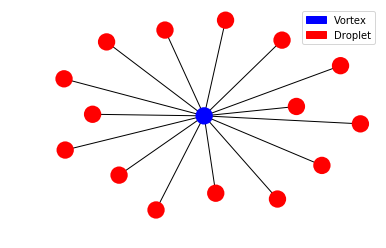

In [4]:
# View the Cortix network created

cortix.draw_network()
plt.show()

## Run network simulation<a id="run"></a>

In [5]:
# Run the simulation!

cortix.run()

[36743] 2019-08-07 07:42:06,857 - cortix - INFO - Launching Module <cortix.examples.vortex.Vortex object at 0x1519174b70>
[36743] 2019-08-07 07:42:06,865 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x15198f9f60>
[36743] 2019-08-07 07:42:06,876 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x151995a4e0>


Vortex::time[min] = 0.0


[36743] 2019-08-07 07:42:06,889 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x151995aeb8>
[36743] 2019-08-07 07:42:06,903 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x1519961860>
[36743] 2019-08-07 07:42:06,917 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x1519967208>
[36743] 2019-08-07 07:42:06,938 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x1519967860>
[36743] 2019-08-07 07:42:06,958 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x151996e198>
[36743] 2019-08-07 07:42:06,971 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x151996ea90>
[36743] 2019-08-07 07:42:06,986 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x15199763c8>
[36743] 2019-08-07 07:42:06,999 - cortix - INFO - Launching Module <cortix.examples.droplet.Droplet object at 0x1519976978>
[36743] 

Vortex::time[min] = 1.0
Vortex::time[min] = 2.0


[36743] 2019-08-07 07:42:31,533 - cortix - INFO - Module <cortix.examples.vortex.Vortex object at 0x1519174b70> getting new state
[36743] 2019-08-07 07:42:31,596 - cortix - INFO - Module <cortix.examples.droplet.Droplet object at 0x1519983a90> getting new state
[36743] 2019-08-07 07:42:31,605 - cortix - INFO - Module <cortix.examples.droplet.Droplet object at 0x1519961860> getting new state
[36743] 2019-08-07 07:42:31,617 - cortix - INFO - Module <cortix.examples.droplet.Droplet object at 0x151995aeb8> getting new state
[36743] 2019-08-07 07:42:31,629 - cortix - INFO - Module <cortix.examples.droplet.Droplet object at 0x151996e198> getting new state
[36743] 2019-08-07 07:42:31,644 - cortix - INFO - Module <cortix.examples.droplet.Droplet object at 0x151995a4e0> getting new state
[36743] 2019-08-07 07:42:31,662 - cortix - INFO - Module <cortix.examples.droplet.Droplet object at 0x15198f9f60> getting new state
[36743] 2019-08-07 07:42:31,673 - cortix - INFO - Module <cortix.examples.drop

## Results inspection through Cortix<a id="inspect"></a>

In [6]:
'''List of modules in Cortix'''

cortix.modules

### All droplets<a id="dataplot"></a>

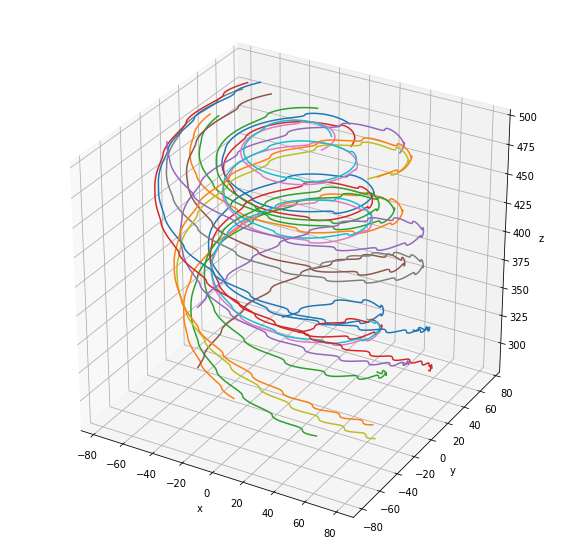

In [11]:
'''DataPlot Module State'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

position_histories = list()
for m in cortix.modules[1:]:
    position_histories.append( m.state.get_quantity_history('position')[0].value )
    
fig = plt.figure(1)
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
for p in position_histories:
    x = [u[0] for u in p]
    y = [u[1] for u in p]
    z = [u[2] for u in p]
    ax.plot(x,y,z)
plt.rcParams['figure.figsize'] = [10,10]
plt.show()

Trajectories of all droplets released from random positions at 500-m altitude. Multiprocessing parallel run with number of processes corresponding to all modules: all `Droplet` modules, 1 `Vortex` module,
and 1 Cortix master process.

### Individual droplet modules<a id="droplet"></a>

time unit =  s
speed unit =  m/s


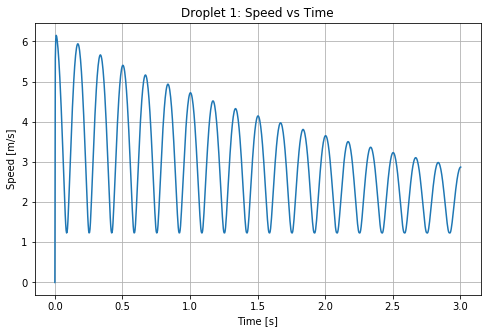

In [15]:
'''Droplet 1 Module State'''

droplet_1 = cortix.modules[2]
(speed_quant,time_unit) = droplet_1.state.get_quantity_history('speed')
print('time unit = ',time_unit)
print('speed unit = ',speed_quant.unit)
#speed_quant
speed_quant.plot(x_scaling=1/const.minute,title='Droplet 1: Speed vs Time',x_label='Time [s]', y_label='Speed [m/s]')
plt.rcParams['figure.figsize'] = [8,5]
plt.grid()
plt.show()

time unit =  s
rad. pos. unit =  m


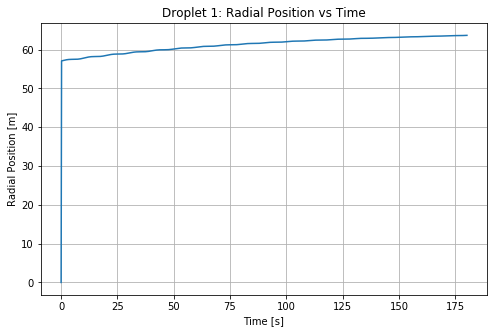

In [21]:
(rad_pos_quant,time_unit) = droplet_1.state.get_quantity_history('radial-position')
print('time unit = ',time_unit)
print('rad. pos. unit = ',rad_pos_quant.unit)
rad_pos_quant.plot(title='Droplet 1: Radial Position vs Time',x_label='Time [s]', y_label='Radial Position [m]')
plt.rcParams['figure.figsize'] = [8,5]
plt.grid()
plt.show()

time unit =  s
speed unit =  m/s


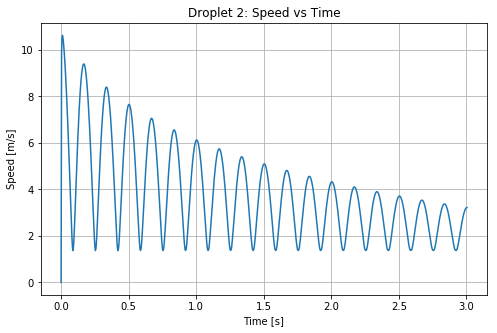

In [23]:
'''Droplet 2 Module State'''

droplet_2 = cortix.modules[4]
(speed_quant,time_unit) = droplet_2.state.get_quantity_history('speed')
print('time unit = ',time_unit)
print('speed unit = ',speed_quant.unit)
#speed_quant
speed_quant.plot(x_scaling=1/const.minute,title='Droplet 2: Speed vs Time',x_label='Time [s]', y_label='Speed [m/s]')
plt.rcParams['figure.figsize'] = [8,5]
plt.grid()
plt.show()

time unit =  s
rad. pos. unit =  m


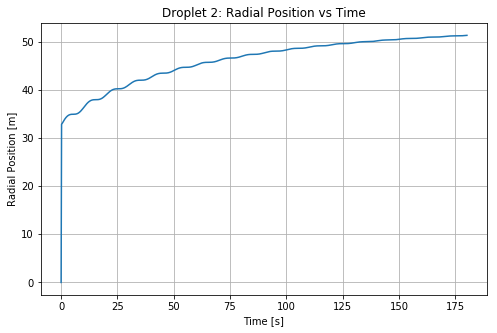

In [26]:
(rad_pos_quant,time_unit) = droplet_2.state.get_quantity_history('radial-position')
print('time unit = ',time_unit)
print('rad. pos. unit = ',rad_pos_quant.unit)
rad_pos_quant.plot(title='Droplet 2: Radial Position vs Time',x_label='Time [s]', y_label='Radial Position [m]')
plt.rcParams['figure.figsize'] = [8,5]
plt.grid()
plt.show()